# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Palaniappan Muthukkaruppan
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Any code is allowed from the class text books or class provided code.__
- Please do not change the file names. The FAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and FAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`).

In [2]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis (55 pts)

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [3]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('/Users/yashpasar/Desktop/MSIM/718/HW3/servo.data', 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))
servo_df.show(n=5)

Py4JError: An error occurred while calling None.org.apache.spark.api.python.PythonRDD. Trace:
py4j.Py4JException: Constructor org.apache.spark.api.python.PythonRDD([class org.apache.spark.rdd.ParallelCollectionRDD, class org.apache.spark.api.python.PythonFunction, class java.lang.Boolean]) does not exist
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:179)
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:196)
	at py4j.Gateway.invoke(Gateway.java:237)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)



In [6]:
# Load the data in this cell if you are using databricks
servo_df = spark.createDataFrame(pd.read_csv('/dbfs/FileStore/tables/servo.data',
sep=',',
header=None,
names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))
servo_df.show(n=5)

+-----+-----+-----+-----+----------+
motor|screw|pgain|vgain| rise_time|
+-----+-----+-----+-----+----------+
 E| E| 5| 4|0.28125095|
 B| D| 6| 5| 0.5062525|
 D| D| 4| 3|0.35625148|
 B| A| 3| 2| 5.500033|
 D| B| 6| 5|0.35625148|
+-----+-----+-----+-----+----------+
only showing top 5 rows

# 1. Explore the data (15 pts)

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`.

In [10]:
# create `servo_sample_df`
servo_sample_df = servo_df.limit(20)
servo_sample_df.show()
#raise NotImplementedError()

+-----+-----+-----+-----+------------------+
motor|screw|pgain|vgain| rise_time|
+-----+-----+-----+-----+------------------+
 E| E| 5| 4| 0.28125095|
 B| D| 6| 5| 0.5062525|
 D| D| 4| 3| 0.35625148|
 B| A| 3| 2| 5.500033|
 D| B| 6| 5| 0.35625148|
 E| C| 4| 3|0.8062545999999999|
 C| A| 3| 2| 5.100014|
 A| A| 3| 2|5.7000421999999995|
 C| A| 6| 5| 0.76875436|
 D| A| 4| 1| 1.0312537|
 B| E| 6| 5| 0.46875226|
 E| C| 5| 4| 0.39375174|
 B| C| 4| 1| 0.28125095|
 E| C| 3| 1| 1.1|
 C| C| 5| 4| 0.5062525|
 E| B| 3| 2|1.8999897000000001|
 D| C| 3| 1| 0.9000011|
 B| C| 5| 4| 0.46875226|
 B| B| 5| 4| 0.5437528|
 C| E| 4| 2| 0.20625044|
+-----+-----+-----+-----+------------------+

In [11]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(2 pts**) Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

In [13]:
servo_pandas_df = servo_sample_df.select("*").toPandas()

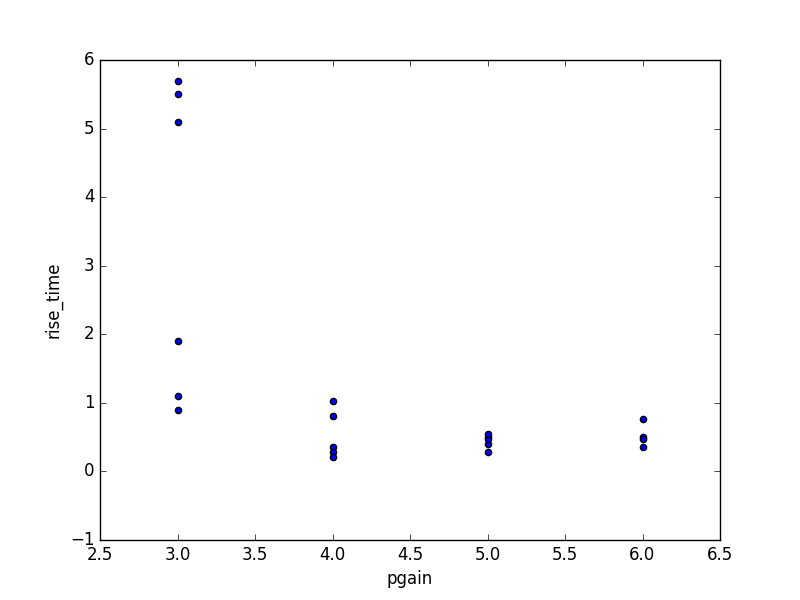

In [14]:
# YOUR CODE HERE
plot01 = servo_pandas_df.plot.scatter(x = 'pgain',y =  'rise_time')
display(plot01.figure)
#raise NotImplementedError()

**(2 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

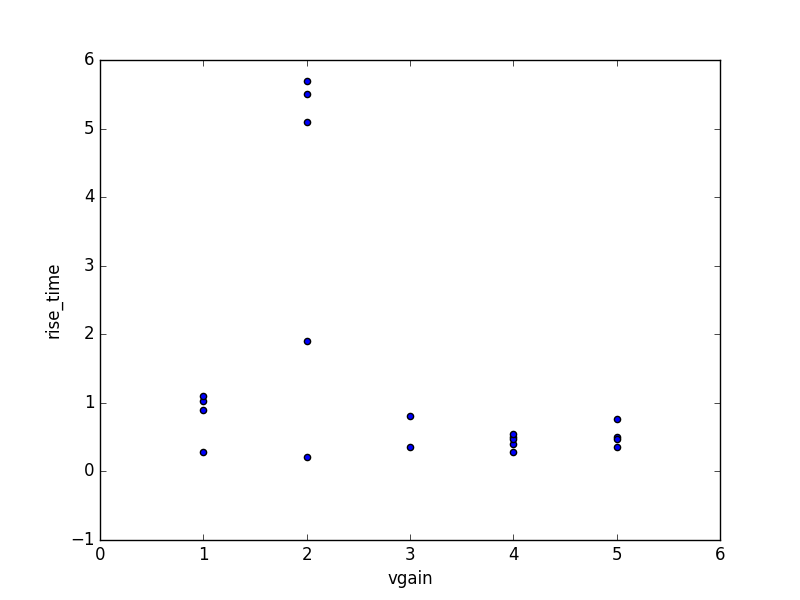

In [16]:
# YOUR CODE HERE
plot02 = servo_pandas_df.plot.scatter(x = 'vgain',y =  'rise_time')
display(plot02.figure)
#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [19]:
# create `servo_corr_df` here
servo_corr_df = servo_df.select(fn.corr("pgain","rise_time").alias('corr_pgain_rise_time'), fn.corr("vgain","pgain").alias('corr_vgain_pgain'), fn.corr("vgain","rise_time").alias('corr_vgain_rise_time'))
servo_corr_df.first().asDict().values()
#raise NotImplementedError()

Out[ 9 ]: dict_values([0.8122683058183874, -0.5981287119612234, -0.36438266626914595])

In [20]:
## 5 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})

np.testing.assert_almost_equal(sorted(list(servo_corr_df.first().asDict().values())),
                               [-0.5981287119612234, -0.36438266626914595, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [23]:
dataset_rdd = servo_df.rdd.map(list)

In [24]:
# YOUR CODE HERE
def avg_map_motor_func(row):
    return (row[0], (row[4], 1))
  
def avg_reduce_motor_func(value1, value2):
  return ((value1[0] + value2[0]), value1[1] + value2[1]) 

  
motor_rdd = dataset_rdd.map(avg_map_motor_func).reduceByKey(avg_reduce_motor_func).mapValues(lambda x: x[0]/x[1]).sortBy(lambda x: -x[1])
motor_rdd.collect()

motor_rise_time_df = motor_rdd.toDF()
motor_rise_time_df.show()
#raise NotImplementedError()

+---+------------------+
 _1| _2|
+---+------------------+
 A| 1.761110668888889|
 B|1.6819423677777776|
 C|1.2540610067500002|
 E|1.1448932081818182|
 D|0.9176125145454544|
+---+------------------+

In [25]:
# 2 pts
test_array = np.array(motor_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect())
test_cats = np.array(test_array[:,0])
test_floats = np.array(test_array[:,1], dtype=np.float)

np.testing.assert_almost_equal(test_floats, [1.761110668888889, 1.6819423677777776, 1.2540610067500002, 
                                             1.1448932081818182, 0.9176125145454544])
np.testing.assert_equal(test_cats, ['A', 'B', 'C', 'E', 'D'])

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [27]:
# YOUR CODE HERE
def avg_map_screw_func(row):
    return (row[1], (row[4], 1))
  
def avg_reduce_screw_func(value1, value2):
  return ((value1[0] + value2[0]), value1[1] + value2[1]) 

  
screw_rdd = dataset_rdd.map(avg_map_screw_func).reduceByKey(avg_reduce_screw_func).mapValues(lambda x: x[0]/x[1]).sortBy(lambda x: -x[1])
screw_rdd.collect()

screw_rise_time_df = screw_rdd.toDF()
screw_rise_time_df.show()
#raise NotImplementedError()

+---+------------------+
 _1| _2|
+---+------------------+
 A| 1.768461212142857|
 B|1.3919625091428571|
 C|1.2485862280645161|
 E|1.2256432917241378|
 D|1.1612471173333332|
+---+------------------+

In [28]:
# 2 pts
np.testing.assert_array_equal(np.array(screw_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect()),
                                  [['A', '1.768461212142857'],
       ['B', '1.3919625091428571'],
       ['C', '1.2485862280645161'],
       ['E', '1.2256432917241378'],
       ['D', '1.1612471173333332']])

# Feature engineering (5 pts)

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [31]:
categ1 = servo_df.select('motor').distinct().rdd.flatMap(lambda x:x).collect()
type(categ1)

Out[ 16 ]: list

In [32]:
# create dummy_df below
# YOUR CODE HERE
categ1 = servo_df.select('motor').distinct().rdd.flatMap(lambda x:x).collect()
exprs1 = [fn.when(fn.col('motor') == cat,1).otherwise(0).alias('motor_' + str(cat)) for cat in categ1]

categ2 = servo_df.select('screw').distinct().rdd.flatMap(lambda x:x).collect()
exprs2 = [fn.when(fn.col('screw') == cat,1).otherwise(0).alias('screw_' + str(cat)) for cat in categ2]

dummy_df = servo_df.select(exprs1+exprs2+servo_df.columns)

dummy_df = dummy_df.select('motor_A',
 'motor_B',
 'motor_C',
 'motor_E',
 'pgain',
 'rise_time',
 'screw_A',
 'screw_B',
 'screw_D',
 'screw_E',
 'vgain')
dummy_df.toPandas().head()

#raise NotImplementedError()

,motor_A,motor_B,motor_C,motor_E,pgain,rise_time,screw_A,screw_B,screw_D,screw_E,vgain
0,0,0,0,1,5,0.281251,0,0,0,1,4
1,0,1,0,0,6,0.506252,0,0,1,0,5
2,0,0,0,0,4,0.356251,0,0,1,0,3
3,0,1,0,0,3,5.500033,1,0,0,0,2
4,0,0,0,0,6,0.356251,0,1,0,0,5


In [33]:
# 5 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)
np.testing.assert_equal(set(dummy_df.columns), {'motor_A',
 'motor_B',
 'motor_C',
 'motor_E',
 'pgain',
 'rise_time',
 'screw_A',
 'screw_B',
 'screw_D',
 'screw_E',
 'vgain'})
np.testing.assert_approx_equal(dummy_df.rdd.flatMap(lambda x: x.asDict().values()).sum(), 
                              1631.0813007799998, significant=2)

# Model comparison (15 pts) 

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [35]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training: 111
# points in validation: 42
# points in testing: 14

## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [38]:
# create `pipe_model1` below
# YOUR CODE HERE
pipe_model1 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['pgain'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='rise_time')  
]).fit(training_df)
#raise NotImplementedError()

In [39]:
pipe_model1.stages[1].coefficients

Out[ 21 ]: DenseVector([-0.8969])

In [40]:
pipe_model1.stages[1].intercept

Out[ 22 ]: 5.107359190930082

In [41]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [43]:
# YOUR CODE HERE
pipe_model2 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['vgain'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='rise_time')  
]).fit(training_df)
#raise NotImplementedError()

In [44]:
pipe_model2.stages[1].intercept

Out[ 25 ]: 2.203017090774904

In [45]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [47]:
# create `pipe_model2` below
# YOUR CODE HERE
pipe_model3 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['motor_A', 'motor_B', 'motor_C', 'motor_E', 'screw_A', 'screw_B', 'screw_D', 'screw_E','pgain','vgain'],     outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='rise_time')  
]).fit(training_df)
#raise NotImplementedError()

In [48]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))

# Compare models (15 pts)

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [51]:
rmse = fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')

In [52]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE

rmse1_df = pipe_model1.transform(validation_df).select(rmse)
rmse2_df = pipe_model2.transform(validation_df).select(rmse)
rmse3_df = pipe_model3.transform(validation_df).select(rmse)
#raise NotImplementedError()

In [53]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+------------------+
 rmse|
+------------------+
1.3076031643280146|
+------------------+

+------------------+
 rmse|
+------------------+
1.4884177186551333|
+------------------+

+-----------------+
 rmse|
+-----------------+
1.199668049260884|
+-----------------+

In [54]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [56]:
# assign best model (the best pipeline transformer) to a variable best_model below
# YOUR CODE HERE
def best_model_predictor(model1, model2, model3):
  x = rmse1_df.collect()
  y = rmse2_df.collect()
  z = rmse3_df.collect()
  if x < y and x < z:
    return(pipe_model1, x)
  elif y < x and y < z:
    return(pipe_model2, y)
  else:
    return(pipe_model3, z)
  
predictor = best_model_predictor(rmse1_df, rmse2_df, rmse3_df)

best_model = predictor[0]
print(best_model)
#raise NotImplementedError()

PipelineModel_a9a1fcfc5a67

In [57]:
# (5 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [59]:
# create rmse_best_df
# YOUR CODE HERE
rmse_best_df = best_model.transform(testing_df).select(rmse)
#raise NotImplementedError()

In [60]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

(2 pts) What is the best estimated generalization performance of the best model? Answer in the cell below

In [62]:
# YOUR CODE HERE
rmse_best_df.show()
#raise NotImplementedError()

+------------------+
 rmse|
+------------------+
1.1026925645222103|
+------------------+

# Do inference with best model (5 pts)

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and add a `StandardScaler` that subtracts the mean and divides by the standard deviation to the pipeline. Fit such pipeline to the **entire training data** (all of `dummy_df`).

In [65]:
# create `pipe_model_best` below
# YOUR CODE HERE
pipe_model_best = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['motor_A', 'motor_B', 'motor_C', 'motor_E', 'screw_A', 'screw_B', 'screw_D', 'screw_E','pgain','vgain'], outputCol='features'),feature.StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features"),
  regression.LinearRegression(featuresCol='scaled_features', labelCol='rise_time')  
]).fit(training_df)
#pipe_model_best.transform(validation_df).show(20, False)
#raise NotImplementedError()

In [66]:
# (2 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), feature.StandardScalerModel)
np.testing.assert_equal(type(pipe_model_best.stages[2]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[2].coefficients.shape, (10,))

**(3 pts)** Since all features on `dummy_df` were standardized, we can compare their importance directly by looking at the coefficients of the linear regression. Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [68]:
pipe_model_best.stages[2].coefficients
#For every one unit of change in 'motor_A' & 'vgain', the change in 'rise_time' is about 0.5734 & 0.7971 respectively. 
#Since these changes are the highest positive changes, they are the top 2 most important features for increasing rise_time.
#For every one unit of change in 'pgain', the change in 'rise_time' is about - 1.6426. 
#Since there is only one negative change, 'pgain' is the  most important feature for decreasing rise_time.

Out[ 41 ]: DenseVector([0.5734, 0.5407, 0.5151, 0.2661, 0.5407, 0.1278, 0.0623, 0.0827, -1.6703, 0.7971])